# Harmonic experiment

In [ ]:
%pip install --upgrade plotly numpy nbformat kaleido pandas

In [21]:
import glob
import os
import pandas as pd
import numpy as np
import re
import plotly.express as px
import plotly.io as pio
from pathlib import Path
from IPython.display import display, Image

pio.defaults.mathjax = None

anonymizer = True
force = True

root_dir = Path.cwd()

def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<fuzzy-pytorch>")
    return Path(path_str)

results_dir = root_dir / "results"
print("Results directory:", anondir(results_dir))

Results directory: <fuzzy-pytorch>/results


In [22]:
def extract_hex(line):
    return float.fromhex(line.split("(")[1].split(")")[0])


def extract_values_default(file):
    with open(file, "r") as f:
        values = map(extract_hex, f.read().splitlines())
    return np.fromiter(values, dtype=np.float64)


def extract_cadna_line(line):
    # RESULT:  +5.18738175e+00 -- +5.18737698e+00 -- +5.18738509e+00
    return re.findall(r"\+\d+\.\d+e[+-]\d+", line)


def extract_values_cadna(file):
    with open(file, "r") as f:
        values = map(extract_cadna_line, f.read().splitlines())
        # flatten list of lists
        values = [item for sublist in values for item in sublist]
    return np.fromiter(values, dtype=np.float64)


def extract_values(file, tool):
    if "cadna" in tool:
        return extract_values_cadna(file)
    else:
        return extract_values_default(file)


def load_data(directory):
    files = glob.glob(os.path.join(directory, "*.txt"))
    df = pd.DataFrame(columns=["tool", "mode", "iterations"])
    for file in files:
        tool, mode, iterations = os.path.splitext(os.path.basename(file))[0].split("-")
        values = extract_values(file, tool)
        mean = np.mean(values)
        std = np.std(values)
        _df = pd.DataFrame(
            {
                "tool": [tool],
                "mode": [mode],
                "iterations": [int(iterations)],
                "mean": [mean],
                "std": [std],
            }
        )
        df = pd.concat([df, _df])
    return df

In [27]:
results_file = root_dir / "harmonic-numerics.csv"
if not results_file.exists and not force:
  df = load_data(results_file)
  df.to_csv(results_file)
else:
  df = pd.read_csv(results_file)
df

,tool,mode,iterations,mean,std
0,verificarlo,perf,613590,13.904262,0.000148
1,prism_ud,perf,37649,11.113365,0.000164
2,cadna,dbg,613590,13.891808,0.005804
3,prism_sr,perf,2477076,15.300161,0.000584
4,prism_ud,perf,284,6.227940,0.000005
...,...,...,...,...,...
1795,verrou_cestac,dbg,14849,10.182983,0.000011
1796,baseline_float,perf,100,5.187378,0.000000
1797,baseline_double,dbg,486260,13.671716,0.000000
1798,cadna,perf,3678,8.787480,0.000036


In [28]:
marker_map = {
    "baseline_double": "star",
    "baseline_float": "hexagram",
    "verrou_cestac": "x",
    "cadna": "x",
    "verrou_sr": "triangle-up",
    "prism_sr": "triangle-up",
    "prism_ud": "diamond",
    "sr": "triangle-up",
    "verificarlo": "triangle-up",
}

legend_map = {
    "prism_sr": "PRISM SR",
    "baseline_double": "IEEE binary64",
    "cadna": "CESTAC",
    "verificarlo": "MCA RR",
    "baseline_float": "IEEE binary32",
    "verrou_sr": "Verrou SR",
    "sr": "FM SR",
    "prism_ud": "PRISM UD",
    "verrou_cestac": "Verrou CESTAC",
}

legendgroup_map = {
    "prism_sr": "PRISM",
    "baseline_double": "IEEE",
    "cadna": "CADNA",
    "verificarlo": "MCA",
    "baseline_float": "IEEE",
    "verrou_sr": "VERROU",
    "sr": "SR",
    "prism_ud": "PRISM",
    "verrou_cestac": "VERROU",
}

colors_map = {
    "IEEE": "#a80ca8",
    "Verrou": "#ff7f0e",
    "PRISM": "#1f77b4",
    "CESTAC": "#1fb438",
    "FM SR": "#26b7e4",
    "MCA RR": "#f10202",
}

color_map = {
    "PRISM": colors_map["PRISM"],
    "VERROU": colors_map["Verrou"],
    "CADNA": colors_map["CESTAC"],
    "IEEE": colors_map["IEEE"],
    "SR": colors_map["FM SR"],
    "MCA": colors_map["MCA RR"],
}

## Combined Mean and Standard Deviation Plots

In [29]:
from plotly.subplots import make_subplots

df = pd.read_csv("harmonic-numerics.csv")
df.sort_values(by=["iterations"], inplace=True)
df_perf = df[df["mode"] == "perf"]

# Create subplots with titles - Standard Deviation left, Average right
fig = make_subplots(
    rows=1, cols=2, x_title="Iteration", horizontal_spacing=0.05  # Decreased separation
)

# Create Std plot (left subplot)
fig_std = px.scatter(
    df_perf,
    x="iterations",
    y="std",
    color="tool",
    log_x=True,
    log_y=True,
)

# Apply all the styling from original std plot
for tool in df["tool"].unique():
    marker = marker_map.get(tool, "diamond")
    fig_std.update_traces(marker_symbol=marker, selector=dict(name=tool))

fig_std.for_each_trace(lambda t: t.update(legendgroup=(legendgroup_map[t.name])))

for tool in df["tool"].unique():
    new_name = legend_map.get(tool, tool)
    fig_std.for_each_trace(lambda t: t.update(name=new_name) if t.name == tool else ())

for trace in fig_std.data:
    trace.update(marker=dict(color=color_map[trace.legendgroup]))
    trace.update(line=dict(color=color_map[trace.legendgroup]))

fig_std.update_traces(marker=dict(size=6))
fig_std.update_traces(marker=dict(opacity=0.85))

# Create Mean plot (right subplot)
fig_mean = px.scatter(
    df_perf,
    x="iterations",
    y="mean",
    color="tool",
    log_x=True,
)

# Apply all the styling from original mean plot
for tool in df["tool"].unique():
    marker = marker_map.get(tool, "diamond")
    fig_mean.update_traces(marker_symbol=marker, selector=dict(name=tool))

fig_mean.for_each_trace(lambda t: t.update(legendgroup=(legendgroup_map[t.name])))

for tool in df["tool"].unique():
    new_name = legend_map.get(tool, tool)
    fig_mean.for_each_trace(lambda t: t.update(name=new_name) if t.name == tool else ())

for trace in fig_mean.data:
    trace.update(marker=dict(color=color_map[trace.legendgroup]))
    trace.update(line=dict(color=color_map[trace.legendgroup]))

fig_mean.update_traces(marker=dict(size=6))
fig_mean.update_traces(marker=dict(opacity=0.85))

# Add std traces to left subplot
for trace in fig_std.data:
    fig.add_trace(trace, row=1, col=1)

# Add mean traces to right subplot (without legend to avoid duplication)
for trace in fig_mean.data:
    trace.update(showlegend=False)
    fig.add_trace(trace, row=1, col=2)

# Update axes styling with increased tick font size
fig.update_xaxes(type="log", exponentformat="power")
fig.update_yaxes(
    type="log",
    exponentformat="power",
    title="Standard Deviation",
    row=1,
    col=1,
    tickfont=dict(size=16),
)
fig.update_yaxes(title="Average", side="right", row=1, col=2, tickfont=dict(size=16))

# Set y-axis to show only powers of 10 for left panel (Standard Deviation)
fig.update_yaxes(dtick=1, row=1, col=1)  # dtick=1 for log scale shows only powers of 10
fig.update_xaxes(dtick=1, row=1, col=1)  # dtick=1 for log scale shows only powers of 10

# Apply the same ranges as original plots - now for right subplot (Average)
fig.update_xaxes(range=[6, 7.1], row=1, col=2)
fig.update_yaxes(range=[14, 22], row=1, col=2)

# Reorder legend according to specified order: ieee, prism, verrou, mca, cestac, fm sr
legend_order = ["IEEE", "PRISM", "VERROU", "MCA", "CADNA", "SR"]
ordered_traces = []
for legendgroup in legend_order:
    for trace in fig.data:
        if (
            hasattr(trace, "legendgroup")
            and trace.legendgroup == legendgroup
            and trace.showlegend
        ):
            ordered_traces.append(trace)

# Clear existing traces and add in order
fig.data = []
for trace in ordered_traces:
    fig.add_trace(trace, row=1, col=1)

# Re-add mean traces (right subplot) without legend
for trace in fig_mean.data:
    trace.update(showlegend=False)
    fig.add_trace(trace, row=1, col=2)

# Update layout with centered legend and increased annotation font size for "Iteration"
fig.update_layout(
    font=dict(size=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.25,
        xanchor="center",
        x=0.5,
        itemwidth=30,
        itemsizing="constant",
        font=dict(size=18),
    ),
    margin=dict(l=60, r=60, t=80, b=120),
    width=1400,
    height=600,
    xaxis=dict(
        title=dict(font=dict(size=24))
    ),  # Increased shared x-axis title font size
    annotations=[
        dict(
            text="Iteration",
            x=0.5,
            y=0,
            xref="paper",
            yref="paper",
            xanchor="center",
            yanchor="top",
            yshift=-50,
            showarrow=False,
            font=dict(size=24),  # Increased annotation font size from 16 to 28
        )
    ],
)

fig.show()

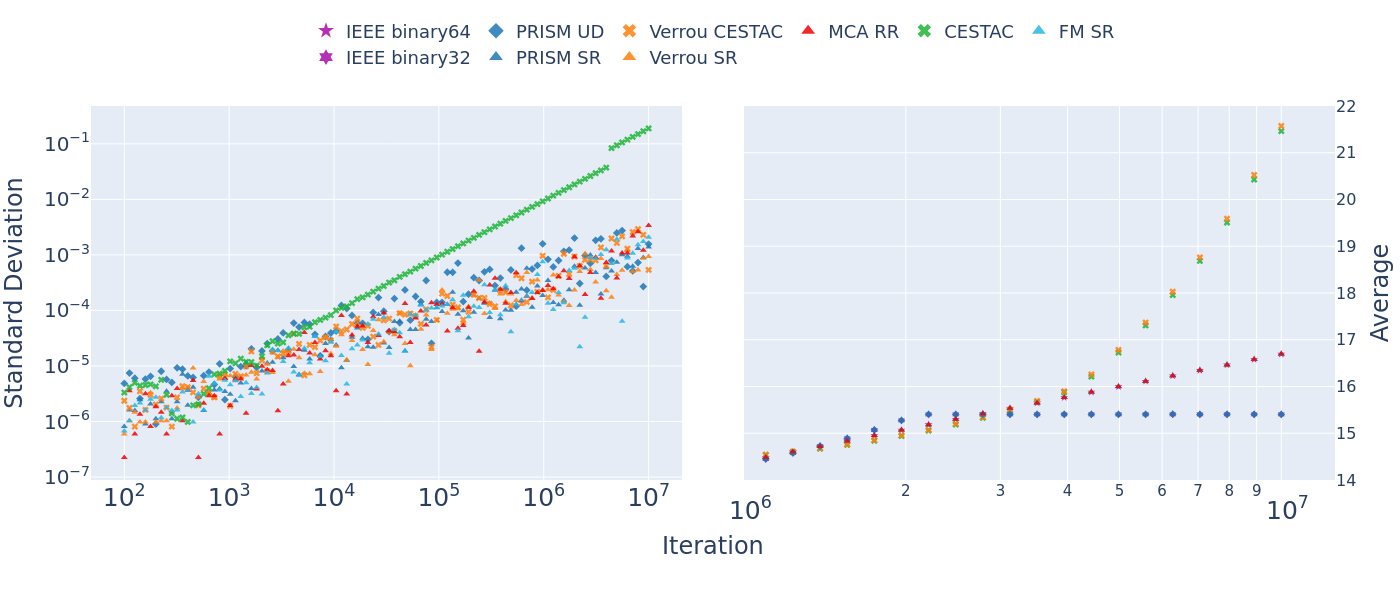

In [34]:
display(Image(fig.to_image(width=1400, height=600)))
fig.update_layout(font=dict(family="Helvetica"))
fig.write_image("harmonic.pdf", width=1400, height=600)

In [ ]:
## Statistical Analysis of Variability

import scipy.stats as stats
from scipy.stats import levene

# Filter for stochastic rounding methods mentioned in the text
sr_methods = ['prism_sr', 'verificarlo', 'verrou_sr', 'sr']
df_sr = df_perf[df_perf['tool'].isin(sr_methods)].copy()

# Extract standard deviations for each method
groups = []
group_names = []
for method in sr_methods:
    method_data = df_sr[df_sr['tool'] == method]['std'].values
    if len(method_data) > 0:
        groups.append(method_data)
        group_names.append(legend_map.get(method, method))

# Perform Levene's test for equality of variances
if len(groups) >= 2:
    levene_stat, levene_p = levene(*groups)
    
    print("Statistical Test for Variability Comparison")
    print("=" * 50)
    print(f"Levene's test statistic: {levene_stat:.4f}")
    print(f"p-value: {levene_p:.4f}")
    print()
    
    if levene_p > 0.05:
        print("Result: No significant difference in variability between methods (p > 0.05)")
        print("The PRISM SR mode exhibits variability comparable to other stochastic rounding methods.")
    else:
        print("Result: Significant difference in variability detected (p ≤ 0.05)")
    
    print()
    print("Group statistics with 95% confidence intervals:")
    confidence_level = 0.95
    alpha = 1 - confidence_level
    
    for i, (group, name) in enumerate(zip(groups, group_names)):
        mean_std = np.mean(group)
        sem = stats.sem(group)  # Standard error of the mean
        n = len(group)
        
        # Calculate 95% CI for the mean using t-distribution
        t_critical = stats.t.ppf(1 - alpha/2, df=n-1)
        ci_lower = mean_std - t_critical * sem
        ci_upper = mean_std + t_critical * sem
        
        print(f"{name}: mean std = {mean_std:.2e} [95% CI: {ci_lower:.2e}, {ci_upper:.2e}], n = {n}")
        
    # Additional pairwise comparisons
    print()
    print("Pairwise F-tests (variance ratios):")
    prism_sr_std = df_sr[df_sr['tool'] == 'prism_sr']['std'].values
    for method in ['verificarlo', 'verrou_sr', 'sr']:
        method_std = df_sr[df_sr['tool'] == method]['std'].values
        if len(method_std) > 0 and len(prism_sr_std) > 0:
            f_stat, f_p = stats.f_oneway(prism_sr_std, method_std)
            method_name = legend_map.get(method, method)
            print(f"PRISM SR vs {method_name}: F = {f_stat:.4f}, p = {f_p:.4f}")
else:
    print("Insufficient data for statistical comparison")

Statistical Test for Variability Comparison
Levene's test statistic: 1.2570
p-value: 0.2888

Result: No significant difference in variability between methods (p > 0.05)
The PRISM SR mode exhibits variability comparable to other stochastic rounding methods.

Group statistics with 95% confidence intervals:
PRISM SR: mean std = 1.65e-04 [95% CI: 1.08e-04, 2.23e-04], n = 100
MCA RR: mean std = 2.41e-04 [95% CI: 1.37e-04, 3.45e-04], n = 100
Verrou SR: mean std = 1.48e-04 [95% CI: 1.00e-04, 1.96e-04], n = 100
FM SR: mean std = 2.10e-04 [95% CI: 1.27e-04, 2.94e-04], n = 100

Pairwise F-tests (variance ratios):
PRISM SR vs MCA RR: F = 1.5800, p = 0.2102
PRISM SR vs Verrou SR: F = 0.2054, p = 0.6509
PRISM SR vs FM SR: F = 0.7751, p = 0.3797
